LDA Accuracy = 97.0
[[  2.84353732   6.06321127   4.22278151  11.00791698   9.72829148]
 [  3.22948323   8.19216551  11.96673625   4.70430105  11.82494404]]
QDA Accuracy = 96.0


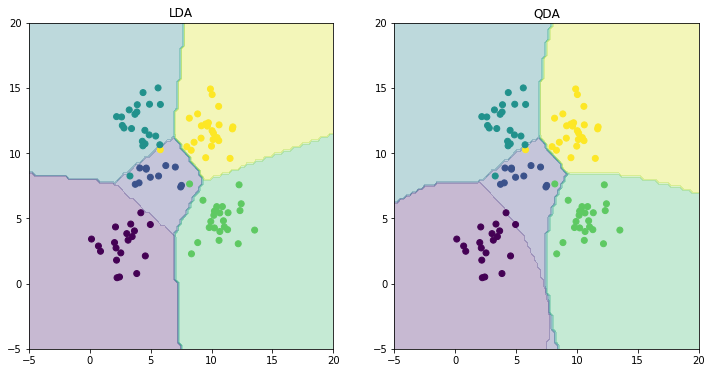

MSE without intercept [ 106775.36155405]
MSE with intercept [ 3707.84018164]


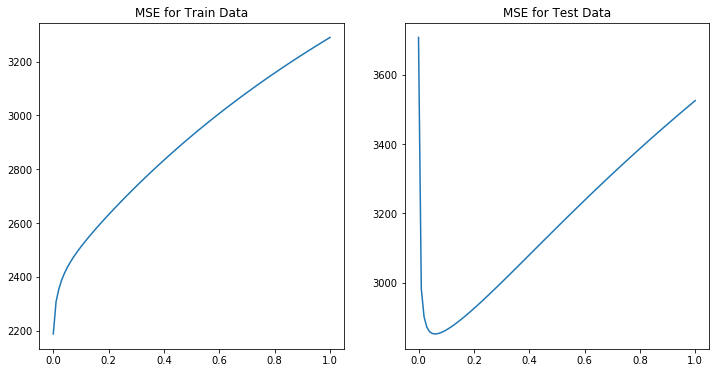

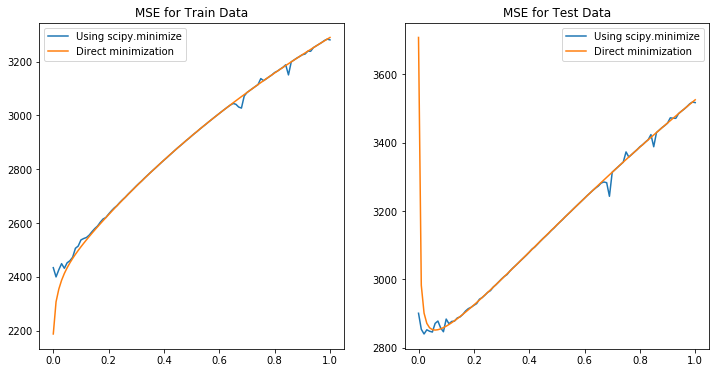

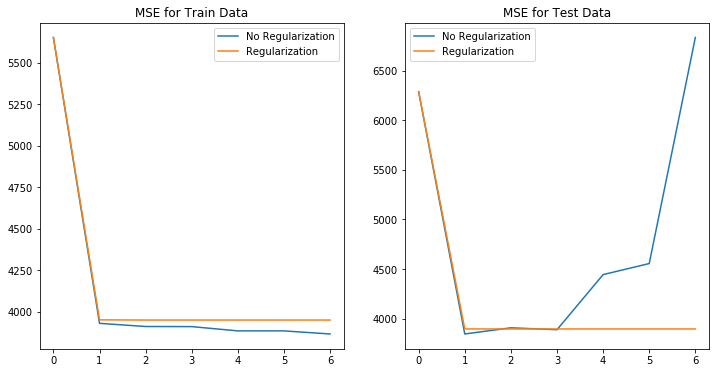

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy.io import loadmat
from numpy.linalg import det, inv
from math import sqrt, pi
import scipy.io
import matplotlib.pyplot as plt
import pickle
import sys
import pandas as pd

def ldaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmat - A single d x d learnt covariance matrix 
    

    k = (np.unique(y))
    n = len(k)
    d = len(X[0])
    shape_mean = (d,n)
    mean = np.empty(shape_mean)
    for i in range (1, n + 1):
        index = np.where(y==i)[0]
        values = X[index,:]
        dataframe = pd.DataFrame(values)
        mean[:, i-1] = dataframe.mean(axis=0)
    shape_cov = (d,d)
    covmat = np.empty(shape_cov)
    Y = X.transpose()
    covmat = np.cov(Y)
    return mean,covmat

def qdaLearn(X,y):
    # Inputs
    # X - a N x d matrix with each row corresponding to a training example
    # y - a N x 1 column vector indicating the labels for each training example
    #
    # Outputs
    # means - A d x k matrix containing learnt means for each of the k classes
    # covmats - A list of k d x d learnt covariance matrices for each of the k classes
    
    # IMPLEMENT THIS METHOD
    k = (np.unique(y))
    n = len(k)
    d = len(X[0])
    shape_mean = (d,n)
    mean = np.empty(shape_mean)
    covmats = []
    for i in range (1, n + 1):
        index = np.where(y==i)[0]
        values = X[index,:]
        dataframe = pd.DataFrame(values)
        mean[:, i-1] = dataframe.mean(axis=0)
        covmats.append(np.cov(values.T))
    print (mean)
    return means,covmats

def ldaTest(means,covmat,Xtest,ytest):
    # Inputs
    # means, covmat - parameters of the LDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    N = len(Xtest)
    b = len(means[0])
    c = len(ytest)
    shape_ypred = (N,1)
    ypred = np.empty(shape_ypred)
    shape_test_pdf = (b,1)
    test_pdf = np.empty(shape_test_pdf)
    sigmaI = np.matrix(covmat).I
    meansT = means.T
    i = 0
    incorrect = 0
    while i < N:
        j = 0
        while j < b:
            first = Xtest[i] - meansT[j]
            test_pdf[j] = np.exp((-1/2)*np.dot(first.T,(np.dot(sigmaI,first).T)))
            j = j + 1
        label = np.argmax(test_pdf)
        ypred[i] = label + 1
        if (ypred[i] != ytest[i]):
            incorrect = incorrect + 1
        i = i + 1
    acc = ((N - incorrect)/N)*100
    return acc,ypred

def qdaTest(means,covmats,Xtest,ytest):
    # Inputs
    # means, covmats - parameters of the QDA model
    # Xtest - a N x d matrix with each row corresponding to a test example
    # ytest - a N x 1 column vector indicating the labels for each test example
    # Outputs
    # acc - A scalar accuracy value
    # ypred - N x 1 column vector indicating the predicted labels

    # IMPLEMENT THIS METHOD
    N = len(Xtest)
    b = len(means[0])
    c = len(ytest)
    shape_ypred = (N,1)
    ypred = np.empty(shape_ypred)
    shape_test_qda = (b,1)
    test_qda = np.empty(shape_test_qda)
    shape_test_pdf = (b,1)
    test_pdf = np.empty(shape_test_pdf)
    #test_qda = []
    covmat_array = np.array(covmats)
    sigmaI = np.matrix(covmat).I
    meansT = means.T
    i = 0
    incorrect = 0
    while i < N:
        pdf = 0
        j = 0
        while j < b:
            first = Xtest[i] - meansT[j]
            a = np.dot(first.T,(np.linalg.inv(covmat_array[j])))
            test_pdf[j] = np.exp((-1/2)*np.dot(a,first))
            sigmaD = np.sqrt(np.linalg.det(covmats[j]))
            test_qda[j] = test_pdf[j]/sigmaD
            j = j + 1
        label = np.argmax(test_qda)
        ypred[i] = label + 1
        if (ypred[i] != ytest[i]):
            incorrect = incorrect + 1
        i = i + 1
    acc = ((N - incorrect)/N)*100
    return acc,ypred

def learnOLERegression(X,y):
    # Inputs:                                                         
    # X = N x d 
    # y = N x 1                                                               
    # Output: 
    # w = d x 1 
	
    # IMPLEMENT THIS METHOD
    X_trans = X.T
    first = np.dot(X_trans,X)
    firstI = np.matrix(first).I
    second = np.dot(X_trans,y)
    w = np.dot(firstI,second)
    
    return w

def learnRidgeRegression(X,y,lambd):
    # Inputs:
    # X = N x d                                                               
    # y = N x 1 
    # lambd = ridge parameter (scalar)
    # Output:                                                                  
    # w = d x 1                                                                

    # IMPLEMENT THIS METHOD
    d = len(X[0])
    identity_mat = np.identity(d)
    X_trans = X.T
    first = np.dot(X_trans,X)
    second = lambd*identity_mat
    add = first + second
    add_inv = np.matrix(add).I
    w = np.dot(np.dot(add_inv,X_trans),y)
    return w

def testOLERegression(w,Xtest,ytest):
    # Inputs:
    # w = d x 1
    # Xtest = N x d
    # ytest = X x 1
    # Output:
    # mse
    
    # IMPLEMENT THIS METHOD
    N = len(Xtest)
    y = np.dot(Xtest,np.array(w))
    loss = (ytest - y)
    squared_loss = loss*loss
    mse = np.sum(squared_loss,axis=0)/N 
    return mse

def regressionObjVal(w, X, y, lambd):

    # compute squared error (scalar) and gradient of squared error with respect
    # to w (vector) for the given data X and y and the regularization parameter
    # lambda                                                                  

    # IMPLEMENT THIS METHOD
    N = len(w)
    w = w.reshape(65,1)
    w_trans = w.T
    a = np.dot(X,w)
    first = np.subtract(y,a)
    first_squared = np.square(first)
    first_sum = np.sum(first_squared)/2
    second = (lambd * np.dot(w_trans,w))/2
    error = np.add(first_sum,second)
    error_grad = np.dot(np.dot(X.T, X), w) - np.dot(X.T, y) + lambd * w
    error_grad = error_grad.flatten()
    return error, error_grad

def mapNonLinear(x,p):
    # Inputs:                                                                  
    # x - a single column vector (N x 1)                                       
    # p - integer (>= 0)                                                       
    # Outputs:                                                                 
    # Xp - (N x (p+1)) 
	
    # IMPLEMENT THIS METHOD
    #N = len(x)
    N = len(x)
    mapl = np.ones((N, p+1))
    for i in range(1, p+1):
        mapl[:, i] = pow(x,i)
    return mapl


# Main script

# Problem 1
# load the sample data                                                                 
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('sample.pickle','rb'),encoding = 'latin1')

# LDA
means,covmat = ldaLearn(X,y)
ldaacc,ldares = ldaTest(means,covmat,Xtest,ytest)
print('LDA Accuracy = '+str(ldaacc))
# QDA
means,covmats = qdaLearn(X,y)
qdaacc,qdares = qdaTest(means,covmats,Xtest,ytest)
print('QDA Accuracy = '+str(qdaacc))

#plotting boundaries
x1 = np.linspace(-5,20,100)
x2 = np.linspace(-5,20,100)
xx1,xx2 = np.meshgrid(x1,x2)
xx = np.zeros((x1.shape[0]*x2.shape[0],2))
xx[:,0] = xx1.ravel()
xx[:,1] = xx2.ravel()

fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)

zacc,zldares = ldaTest(means,covmat,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zldares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('LDA')

plt.subplot(1, 2, 2)

zacc,zqdares = qdaTest(means,covmats,xx,np.zeros((xx.shape[0],1)))
plt.contourf(x1,x2,zqdares.reshape((x1.shape[0],x2.shape[0])),alpha=0.3)
plt.scatter(Xtest[:,0],Xtest[:,1],c=ytest.flatten())
plt.title('QDA')

plt.show()
# Problem 2
if sys.version_info.major == 2:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'))
else:
    X,y,Xtest,ytest = pickle.load(open('diabetes.pickle','rb'),encoding = 'latin1')

# add intercept
X_i = np.concatenate((np.ones((X.shape[0],1)), X), axis=1)
Xtest_i = np.concatenate((np.ones((Xtest.shape[0],1)), Xtest), axis=1)

w = learnOLERegression(X,y)
mle = testOLERegression(w,Xtest,ytest)

w_i = learnOLERegression(X_i,y)
mle_i = testOLERegression(w_i,Xtest_i,ytest)

print('MSE without intercept '+str(mle))
print('MSE with intercept '+str(mle_i))

# Problem 3
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses3_train = np.zeros((k,1))
mses3 = np.zeros((k,1))
for lambd in lambdas:
    w_l = learnRidgeRegression(X_i,y,lambd)
    mses3_train[i] = testOLERegression(w_l,X_i,y)
    mses3[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.subplot(1, 2, 2)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')

plt.show()

# Problem 4
k = 101
lambdas = np.linspace(0, 1, num=k)
i = 0
mses4_train = np.zeros((k,1))
mses4 = np.zeros((k,1))
opts = {'maxiter' : 20}    # Preferred value.                                                
w_init = np.ones((X_i.shape[1],1))
for lambd in lambdas:
    args = (X_i, y, lambd)
    w_l = minimize(regressionObjVal, w_init, jac=True, args=args,method='CG', options=opts)
    w_l = np.transpose(np.array(w_l.x))
    w_l = np.reshape(w_l,[len(w_l),1])
    mses4_train[i] = testOLERegression(w_l,X_i,y)
    mses4[i] = testOLERegression(w_l,Xtest_i,ytest)
    i = i + 1
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(lambdas,mses4_train)
plt.plot(lambdas,mses3_train)
plt.title('MSE for Train Data')
plt.legend(['Using scipy.minimize','Direct minimization'])

plt.subplot(1, 2, 2)
plt.plot(lambdas,mses4)
plt.plot(lambdas,mses3)
plt.title('MSE for Test Data')
plt.legend(['Using scipy.minimize','Direct minimization'])
plt.show()

# Problem 5
pmax = 7
lambda_opt = mses3.argmin()*0.01 # REPLACE THIS WITH lambda_opt estimated from Problem 3
mses5_train = np.zeros((pmax,2))
mses5 = np.zeros((pmax,2))
for p in range(pmax):
    Xd = mapNonLinear(X[:,2],p)
    Xdtest = mapNonLinear(Xtest[:,2],p)
    w_d1 = learnRidgeRegression(Xd,y,0)
    mses5_train[p,0] = testOLERegression(w_d1,Xd,y)
    mses5[p,0] = testOLERegression(w_d1,Xdtest,ytest)
    w_d2 = learnRidgeRegression(Xd,y,lambda_opt)
    mses5_train[p,1] = testOLERegression(w_d2,Xd,y)
    mses5[p,1] = testOLERegression(w_d2,Xdtest,ytest)
fig = plt.figure(figsize=[12,6])
plt.subplot(1, 2, 1)
plt.plot(range(pmax),mses5_train)
plt.title('MSE for Train Data')
plt.legend(('No Regularization','Regularization'))
plt.subplot(1, 2, 2)
plt.plot(range(pmax),mses5)
plt.title('MSE for Test Data')
plt.legend(('No Regularization','Regularization'))
plt.show()